# Evaluation
Super basic eval notebook aimed at N-step ahead forecasts

In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

import sqlalchemy
import time

%matplotlib inline

sys.path.insert(0,"..")
import views_utils.dbutils as dbutils

In [2]:
# db parameters
uname    = "VIEWSADMIN" # CHANGE ME
prefix   = "postgresql"
db       = "views"
port     = "5432"
hostname = "VIEWSHOST"
connectstring = dbutils.make_connectstring(prefix, db, uname, hostname, port)

In [3]:
df = dbutils.db_to_df(connectstring, "landed_test", "nstep_rf100_500")
print(df.head(3))



Connecting to postgresql://VIEWSADMIN@VIEWSHOST:5432/views using sqlalchemy ...  [OK] 
Getting table  landed_test.nstep_rf100_500  from  postgresql://VIEWSADMIN@VIEWSHOST:5432/views ...  [OK] runtime:  8.433927774429321 rows:  384372 rows/seconds:  45574.49509650424
   month_id  pg_id  actual_rf_100  rf_100  p_rf_100  rf_100_li  p_rf_100_li  \
0       409  62356              0     0.0       0.0        0.0          0.0   
1       409  79599              0     0.0       0.0        0.0          0.0   
2       409  79600              0     0.0       0.0        0.0          0.0   

   rf_100_li_dummy  p_rf_100_li_dummy  actual_rf_250        ...          \
0              0.0                0.0              0        ...           
1              0.0                0.0              0        ...           
2              0.0                0.0              0        ...           

   p_rf_250_li  rf_250_li_dummy  p_rf_250_li_dummy  actual_rf_500  rf_500  \
0          0.0              0.0       

In [ ]:
#df.set_index(["month_id", "pg_id"], inplace=True)

In [4]:
def plot_roc(y_test, y_score, name, path=None, xkcd=False):
    fpr, tpr, threshold = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    title = str(name) + " AUC:" + str(roc_auc)
    
    if xkcd:
        plt.xkcd()
        print("xkcd style")
    else:
        plt.rcdefaults()
    
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.title(title)
    plt.ylim((0,1))
    plt.xlim((0,1))

    if path:
        plt.savefig(path)
    else:
        plt.show()
        
def get_actual_pred(df, modelname):
    name_actual = "actual_" + modelname
    name_pred = modelname + "_li_dummy"
    name_p_pred = "p_" + modelname + "_li"
    y_actual = np.array(df[name_actual])
    y_pred = np.array(df[name_pred])
    y_p_pred = np.array(df[name_p_pred])
    return y_actual, y_pred, y_p_pred

def plot_model_roc(df, modelname):
    y_actual,  y_pred, y_p_pred = get_actual_pred(df, modelname)
    plot_roc(y_actual, y_p_pred, modelname)
    
def plot_prediction_hists(df, modelname):
    y_actual, y_pred, y_p_pred = get_actual_pred(df, modelname)
    
    plt.figure()
    plt.title(modelname +" actual")
    plt.hist(y_actual, bins=100)
    plt.show()
    
    plt.figure()
    plt.title(modelname +" pred")
    plt.hist(y_pred, bins=100)
    plt.show()
    
    plt.figure()
    plt.title(modelname + " p_pred")
    plt.hist(y_p_pred, bins=100)
    plt.show()
    
def print_f1(df, modelname):
    y_actual, y_pred, y_p_pred = get_actual_pred(df, modelname)
    f1 = f1_score(y_true=y_actual, y_pred=y_pred)
    print(modelname, " f1:", f1)


def print_confusion(df, modelname):
    y_actual, y_pred, _ = get_actual_pred(df, modelname)
    tn, fp, fn, tp  = confusion_matrix(y_actual, y_pred).ravel()
    print("Confusion matrix ", modelname)
    
    print("tn {} fp {} fn {} tp {}".format(tn, fp, fn, tp))

In [ ]:
y_actual, y_pred, y_p_pred = get_actual_pred(df, "rf")
y_actual

rf_100  f1: 0.218409586057
Confusion matrix  rf_100
tn 381101 fp 1507 fn 1363 tp 401


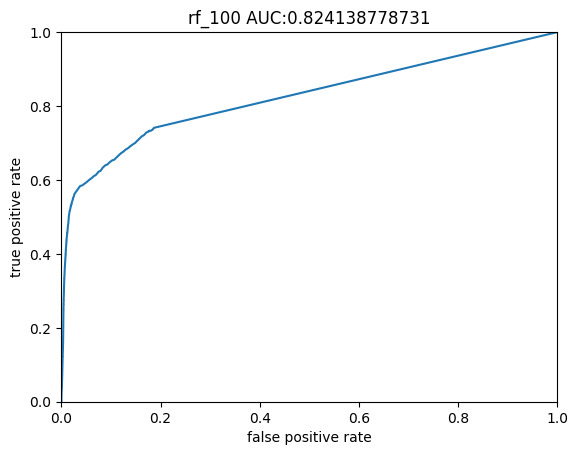

rf_250  f1: 0.218409586057
Confusion matrix  rf_250
tn 381101 fp 1507 fn 1363 tp 401


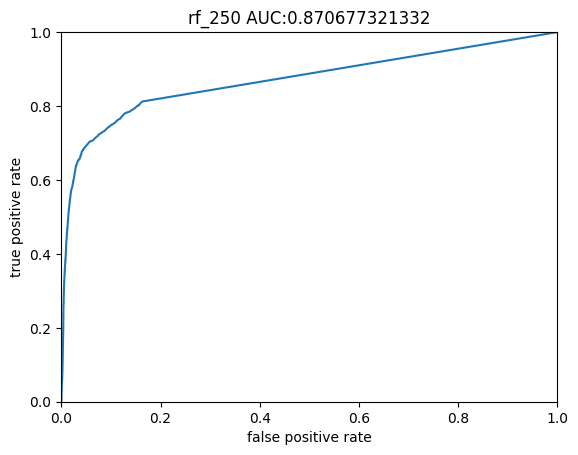

rf_500  f1: 0.218409586057
Confusion matrix  rf_500
tn 381101 fp 1507 fn 1363 tp 401


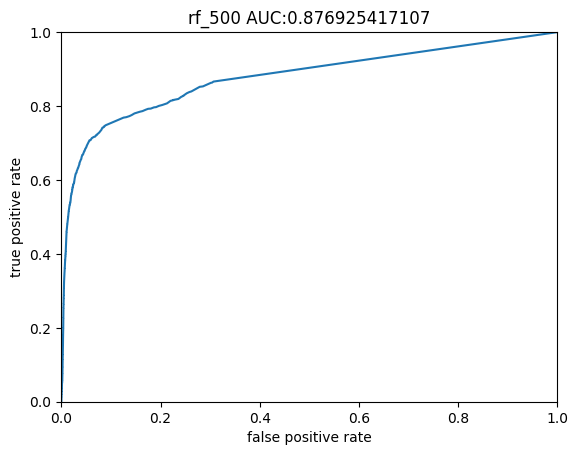

In [5]:
models = ["rf_100", "rf_250", "rf_500"]
for model in models:
        print_f1(df, model)
        #plot_prediction_hists(df, model)
        print_confusion(df, model)
        plot_model_roc(df, model)

In [ ]:
t_start = df.index.get_level_values(0).min()
t_end = df.index.get_level_values(0).max()

for t in range(t_start, t_end+1):
    print(t)
    for model in ["rf"]:
        #print_f1(df, model)
        #plot_prediction_hists(df.loc[t], model)
        print_confusion(df.loc[t], model)
        #plot_model_roc(df.loc[t], model)

In [ ]:
df[['actual_rf', 'rf', 'p_rf', 'rf_li', 'p_rf_li']]

In [ ]:
def make_dummy(df, varname, threshold):
    """ Set varname_dummy=1 if varname above threshold, else 0

    Use for casting probabilities to binary labels 
    or linearly interpolated labels, which become continous, to discrete labels.

    Args:
        df:
        varname: varname of continuous variable
        threshold: float between 0 and 1
    """

    assert 0<=threshold<=1, "Threshold needs to be between 0 and 1"

    mask = df[varname] < threshold
    name_dummy = varname + "_dummy"
    df.loc[mask, name_dummy] = 0
     # ~ inverts the mask, True becomes False    
    df.loc[~mask, name_dummy] = 1
    return df

In [ ]:
df = make_dummy(df, 'mlp_li', 0.5)

In [ ]:
df.mlp_li.mean()

In [ ]:
df.mlp_li_dummy.mean()

In [ ]:
df.mlp.mean()

In [ ]:
df.plot(kind='scatter', x='mlp_li', y='mlp_li_dummy')